# Hate Speech Modell Validierung und Vergleich (ONNX)

Dieses Notebook lädt beide trainierten Modelle als ONNX und evaluiert sie auf dem Testdatensatz.

## Inhalte:
- Laden beider Modelle als ONNX (HuggingFace gbert-base und SageMaker)
- Konvertierung des SageMaker-Modells zu ONNX (falls nötig)
- Laden des Testdatensatzes
- Vorhersagen mit beiden ONNX-Modellen erstellen
- Confusion Matrix
- Classification Report
- ROC Curve
- Precision-Recall Curve
- Verschiedene Metriken und Visualisierungen
- **Modellvergleich: HuggingFace ONNX vs. SageMaker ONNX**


In [135]:
# Installation der benötigten Pakete
%pip install -q transformers torch pandas numpy matplotlib seaborn scikit-learn onnxruntime optimum[onnxruntime]


Note: you may need to restart the kernel to use updated packages.


In [136]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc,
    precision_recall_curve, roc_auc_score
)
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ONNX Runtime für Modell-Inferenz
try:
    import onnxruntime as ort
    ONNXRUNTIME_AVAILABLE = True
except ImportError:
    print("⚠️  ONNX Runtime nicht verfügbar. Installiere es mit: pip install onnxruntime")
    ONNXRUNTIME_AVAILABLE = False

# Optimum für ONNX-Konvertierung
try:
    from optimum.onnxruntime import ORTModelForSequenceClassification
    from transformers.onnx import export
    OPTIMUM_AVAILABLE = True
except ImportError:
    print("⚠️  Optimum nicht verfügbar. ONNX-Konvertierung wird möglicherweise nicht funktionieren.")
    OPTIMUM_AVAILABLE = False

# Setze Style für bessere Visualisierungen
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Alle Pakete erfolgreich importiert")


✅ Alle Pakete erfolgreich importiert


## 1. ONNX-Modelle laden und konvertieren


In [137]:
# Pfade zu den Modellen
# HuggingFace Modell (gbert-base) - ONNX
HF_MODEL_PATH = Path("../notebook/results_gbert-base_gahd_hatespeech_2025-11-04/final_model")
HF_ONNX_PATH = HF_MODEL_PATH / "model.onnx"

# SageMaker Modell - versuche ONNX zu finden oder zu erstellen
SAGEMAKER_MODEL_PATH = Path("../modelsagemaker")
SAGEMAKER_HF_TEXT_PATH = SAGEMAKER_MODEL_PATH / "hf_text"
SAGEMAKER_ONNX_PATH = SAGEMAKER_MODEL_PATH / "model.onnx"

print("="*60)
print("LADE ONNX-MODELLE")
print("="*60)

# 1. HuggingFace ONNX Modell
print(f"\n1. HuggingFace Modell (gbert-base) - ONNX")
print(f"   ONNX-Pfad: {HF_ONNX_PATH}")

if not HF_ONNX_PATH.exists():
    # Suche nach alternativen Pfaden
    possible_paths = [
        Path("notebook/results_gbert-base_gahd_hatespeech_2025-11-04/final_model/model.onnx"),
        Path("results_gbert-base_gahd_hatespeech_2025-11-04/final_model/model.onnx"),
    ]
    for path in possible_paths:
        if path.exists():
            HF_ONNX_PATH = path
            HF_MODEL_PATH = path.parent
            break

if HF_ONNX_PATH.exists():
    # Lade Tokenizer
    hf_tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_PATH)
    
    # Lade ONNX Session
    if ONNXRUNTIME_AVAILABLE:
        hf_onnx_session = ort.InferenceSession(str(HF_ONNX_PATH))
        print(f"   ✅ HuggingFace ONNX-Modell geladen")
        print(f"   Inputs: {[inp.name for inp in hf_onnx_session.get_inputs()]}")
        print(f"   Outputs: {[out.name for out in hf_onnx_session.get_outputs()]}")
    else:
        print(f"   ⚠️  ONNX Runtime nicht verfügbar")
        hf_onnx_session = None
else:
    print(f"   ⚠️  ONNX-Modell nicht gefunden: {HF_ONNX_PATH}")
    hf_onnx_session = None
    hf_tokenizer = None

# 2. SageMaker Modell - konvertiere zu ONNX falls nötig
print(f"\n2. SageMaker Modell - ONNX")
print(f"   SageMaker-Pfad: {SAGEMAKER_MODEL_PATH}")

sagemaker_onnx_session = None
sagemaker_tokenizer = None

if SAGEMAKER_ONNX_PATH.exists():
    print(f"   ✅ ONNX-Modell bereits vorhanden: {SAGEMAKER_ONNX_PATH}")
    if ONNXRUNTIME_AVAILABLE:
        sagemaker_onnx_session = ort.InferenceSession(str(SAGEMAKER_ONNX_PATH))
        # Versuche Tokenizer zu laden
        if SAGEMAKER_HF_TEXT_PATH.exists():
            try:
                sagemaker_tokenizer = AutoTokenizer.from_pretrained(str(SAGEMAKER_HF_TEXT_PATH))
                print(f"   ✅ Tokenizer geladen")
            except Exception as e:
                print(f"   ⚠️  Konnte Tokenizer nicht laden: {e}")
                # Verwende HuggingFace Tokenizer als Fallback
                if hf_tokenizer is not None:
                    sagemaker_tokenizer = hf_tokenizer
                    print(f"   Verwende HuggingFace Tokenizer als Fallback")
        print(f"   ✅ SageMaker ONNX-Modell geladen")
        print(f"   Inputs: {[inp.name for inp in sagemaker_onnx_session.get_inputs()]}")
        print(f"   Outputs: {[out.name for out in sagemaker_onnx_session.get_outputs()]}")
else:
    print(f"   ⚠️  ONNX-Modell nicht gefunden.")
    print(f"   💡 Tipp: Führen Sie zuerst das Notebook 'hateSpeech_convertSagemaker.ipynb' aus,")
    print(f"      um das SageMaker-Modell zu ONNX zu konvertieren.")
    print(f"   ")
    print(f"   Alternativ: Versuche automatische Konvertierung...")
    
    # Prüfe ob model.ckpt existiert (PyTorch Lightning Checkpoint)
    SAGEMAKER_CKPT_PATH = SAGEMAKER_MODEL_PATH / "model.ckpt"
    
    if SAGEMAKER_CKPT_PATH.exists() and SAGEMAKER_HF_TEXT_PATH.exists() and OPTIMUM_AVAILABLE:
        try:
            print(f"   Lade Modell aus Checkpoint: {SAGEMAKER_CKPT_PATH}")
            print(f"   Konfiguration: {SAGEMAKER_HF_TEXT_PATH}")
            
            # Lade Konfiguration
            from transformers import AutoConfig, AutoModelForSequenceClassification
            config = AutoConfig.from_pretrained(str(SAGEMAKER_HF_TEXT_PATH))
            
            # Erstelle Modell mit der Konfiguration
            # Prüfe Anzahl Labels aus assets.json oder config
            import json
            assets_path = SAGEMAKER_MODEL_PATH / "assets.json"
            num_labels = 2  # Standard für Hate Speech Detection
            if assets_path.exists():
                with open(assets_path, 'r') as f:
                    assets = json.load(f)
                    if 'output_shape' in assets and assets['output_shape']:
                        num_labels = assets['output_shape']
                        print(f"   Anzahl Labels aus assets.json: {num_labels}")
            
            # Falls config.num_labels nicht gesetzt ist, setze es
            if not hasattr(config, 'num_labels') or config.num_labels is None:
                config.num_labels = num_labels
            
            print(f"   Erstelle Modell mit {num_labels} Labels...")
            sagemaker_model = AutoModelForSequenceClassification.from_config(config)
            
            # Lade Gewichte aus dem Checkpoint
            print(f"   Lade Gewichte aus Checkpoint...")
            checkpoint = torch.load(str(SAGEMAKER_CKPT_PATH), map_location='cpu')
            
            # Prüfe Checkpoint-Struktur
            if 'state_dict' in checkpoint:
                state_dict = checkpoint['state_dict']
                # Entferne 'model.' Präfix falls vorhanden (PyTorch Lightning)
                new_state_dict = {}
                for k, v in state_dict.items():
                    if k.startswith('model.'):
                        new_state_dict[k[6:]] = v  # Entferne 'model.' Präfix
                    else:
                        new_state_dict[k] = v
                state_dict = new_state_dict
            else:
                state_dict = checkpoint
            
            # Lade Gewichte
            missing_keys, unexpected_keys = sagemaker_model.load_state_dict(state_dict, strict=False)
            if missing_keys:
                print(f"   ⚠️  Fehlende Keys: {len(missing_keys)} (erste 5: {missing_keys[:5]})")
            if unexpected_keys:
                print(f"   ⚠️  Unerwartete Keys: {len(unexpected_keys)} (erste 5: {unexpected_keys[:5]})")
            
            sagemaker_model.eval()
            print(f"   ✅ Modell aus Checkpoint geladen")
            
            # Lade Tokenizer
            sagemaker_tokenizer = AutoTokenizer.from_pretrained(str(SAGEMAKER_HF_TEXT_PATH))
            print(f"   ✅ Tokenizer geladen")
            
            # Konvertiere zu ONNX
            print(f"   Konvertiere zu ONNX: {SAGEMAKER_ONNX_PATH}")
            export(sagemaker_model, sagemaker_tokenizer, str(SAGEMAKER_ONNX_PATH), opset=12)
            
            if SAGEMAKER_ONNX_PATH.exists():
                file_size = SAGEMAKER_ONNX_PATH.stat().st_size / (1024 * 1024)  # MB
                print(f"   ✅ SageMaker-Modell erfolgreich zu ONNX konvertiert")
                print(f"   Dateigröße: {file_size:.2f} MB")
                if ONNXRUNTIME_AVAILABLE:
                    sagemaker_onnx_session = ort.InferenceSession(str(SAGEMAKER_ONNX_PATH))
                    print(f"   ✅ SageMaker ONNX-Modell geladen")
                    print(f"   Inputs: {[inp.name for inp in sagemaker_onnx_session.get_inputs()]}")
                    print(f"   Outputs: {[out.name for out in sagemaker_onnx_session.get_outputs()]}")
            else:
                print(f"   ⚠️  ONNX-Datei wurde nicht erstellt")
        except Exception as e:
            print(f"   ⚠️  Fehler bei ONNX-Konvertierung: {e}")
            import traceback
            print(f"   Detaillierte Fehlermeldung:")
            traceback.print_exc()
    else:
        if not SAGEMAKER_CKPT_PATH.exists():
            print(f"   ⚠️  Checkpoint nicht gefunden: {SAGEMAKER_CKPT_PATH}")
        if not SAGEMAKER_HF_TEXT_PATH.exists():
            print(f"   ⚠️  HuggingFace-Konfiguration nicht gefunden: {SAGEMAKER_HF_TEXT_PATH}")
        if not OPTIMUM_AVAILABLE:
            print(f"   ⚠️  Optimum nicht verfügbar - Konvertierung nicht möglich")

print("="*60)




LADE ONNX-MODELLE

1. HuggingFace Modell (gbert-base) - ONNX
   ONNX-Pfad: ..\notebook\results_gbert-base_gahd_hatespeech_2025-11-04\final_model\model.onnx
   ✅ HuggingFace ONNX-Modell geladen
   Inputs: ['input_ids', 'attention_mask', 'token_type_ids']
   Outputs: ['logits']

2. SageMaker Modell - ONNX
   SageMaker-Pfad: ..\modelsagemaker
   ✅ ONNX-Modell bereits vorhanden: ..\modelsagemaker\model.onnx
   ✅ Tokenizer geladen
   ✅ SageMaker ONNX-Modell geladen
   Inputs: ['input_ids', 'attention_mask']
   Outputs: ['logits']


## 2. Validierungsdatensatz laden


In [138]:
# Lade Validierungsdatensatz
val_df = pd.read_csv("../data/de_hf_112024_test.csv", encoding="utf-8")

# Bereinige Daten
val_df["text"] = val_df["text"].fillna("")
val_df["labels"] = val_df["labels"].astype(int)

print(f"✅ Testdatensat geladen")
print(f"   Anzahl Samples: {len(val_df):,}")
print(f"   Label-Verteilung:")
print(val_df["labels"].value_counts().sort_index())
print(f"\n   Anteil Hate Speech (Label 1): {val_df['labels'].mean()*100:.2f}%")
print(f"\n   Erste Zeilen:")
val_df.head()


✅ Testdatensat geladen
   Anzahl Samples: 2,528
   Label-Verteilung:
labels
0    2213
1     315
Name: count, dtype: int64

   Anteil Hate Speech (Label 1): 12.46%

   Erste Zeilen:


,text,labels
0,Siddhartha Gautama war doch einfach ein Träume...,0
1,"Ich würde es lieben, wenn sich alle Frauen ers...",1
2,"Danke Herr Lindner. Schade, dass die ""Meinungs...",0
3,"Die BILD schreibt: ""Duschen und nach Hause geh...",1
4,Man sollte Macron jetzt nicht im Regen stehen ...,0


## 3. SageMaker Modell direkt aus Checkpoint laden (PyTorch, ohne ONNX)

Alternative: Lade das Modell direkt aus dem Checkpoint und teste es ohne ONNX-Konvertierung.


In [139]:
# Lade SageMaker Modell direkt aus Checkpoint (PyTorch)
print("="*60)
print("SAGEMAKER MODELL DIREKT AUS CHECKPOINT LADEN (PYTORCH)")
print("="*60)

SAGEMAKER_MODEL_PATH = Path("../modelsagemaker")
SAGEMAKER_CKPT_PATH = SAGEMAKER_MODEL_PATH / "model.ckpt"
SAGEMAKER_HF_TEXT_PATH = SAGEMAKER_MODEL_PATH / "hf_text"
ASSETS_JSON_PATH = SAGEMAKER_MODEL_PATH / "assets.json"

sagemaker_pytorch_model = None
sagemaker_pytorch_tokenizer = None

if SAGEMAKER_CKPT_PATH.exists() and SAGEMAKER_HF_TEXT_PATH.exists():
    try:
        from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
        import json
        
        print(f"\n1. Lade Konfiguration...")
        config = AutoConfig.from_pretrained(str(SAGEMAKER_HF_TEXT_PATH))
        print(f"   ✅ Konfiguration geladen: {config.model_type}")
        
        # Bestimme Anzahl Labels
        num_labels = 3  # Standard für SageMaker (hat 3 Klassen)
        if ASSETS_JSON_PATH.exists():
            with open(ASSETS_JSON_PATH, 'r') as f:
                assets = json.load(f)
                if 'output_shape' in assets and assets['output_shape']:
                    num_labels = assets['output_shape']
                    print(f"   Anzahl Labels aus assets.json: {num_labels}")
        
        if not hasattr(config, 'num_labels') or config.num_labels is None:
            config.num_labels = num_labels
        
        print(f"\n2. Erstelle Modell mit {num_labels} Labels...")
        sagemaker_pytorch_model = AutoModelForSequenceClassification.from_config(config)
        
        print(f"\n3. Lade Gewichte aus Checkpoint...")
        checkpoint = torch.load(str(SAGEMAKER_CKPT_PATH), map_location='cpu')
        
        # Extrahiere state_dict
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint
        
        # Bereinige state_dict: Entferne Präfixe und mappe auf Deberta-Struktur
        print(f"   Bereinige state_dict...")
        cleaned_state_dict = {}
        
        for key, value in state_dict.items():
            new_key = key
            
            # Entferne 'position_ids'
            if 'position_ids' in new_key:
                continue
            
            # Entferne doppelte Präfixe
            if new_key.startswith('model.model.'):
                new_key = new_key[12:]  # Entferne 'model.model.'
            elif new_key.startswith('model.'):
                new_key = new_key[6:]  # Entferne 'model.'
            
            # Entferne weitere Präfixe
            for prefix in ['module.', 'backbone.']:
                if new_key.startswith(prefix):
                    new_key = new_key[len(prefix):]
                    break
            
            # Füge 'deberta.' Präfix hinzu für Embedding/Encoder Keys
            if not new_key.startswith('deberta.') and not new_key.startswith('classifier') and not new_key.startswith('pooler') and not new_key.startswith('head'):
                if any(x in new_key for x in ['embeddings', 'encoder']):
                    new_key = 'deberta.' + new_key
            
            # Mappe 'head' auf 'classifier' (AutoGluon verwendet manchmal 'head')
            if new_key.startswith('head.'):
                new_key = 'classifier.' + new_key[5:]
            
            cleaned_state_dict[new_key] = value
        
        print(f"   Original Keys: {len(state_dict)}")
        print(f"   Bereinigte Keys: {len(cleaned_state_dict)}")
        
        # Lade Gewichte
        missing_keys, unexpected_keys = sagemaker_pytorch_model.load_state_dict(cleaned_state_dict, strict=False)
        
        if missing_keys:
            print(f"   ⚠️  Fehlende Keys: {len(missing_keys)}")
            critical = [k for k in missing_keys if 'classifier' in k or 'pooler' in k]
            if critical:
                print(f"      KRITISCH: {critical}")
        else:
            print(f"   ✅ Alle Keys geladen")
        
        if unexpected_keys:
            print(f"   ⚠️  Unerwartete Keys: {len(unexpected_keys)}")
        else:
            print(f"   ✅ Keine unerwarteten Keys")
        
        sagemaker_pytorch_model.eval()
        print(f"\n4. Lade Tokenizer...")
        sagemaker_pytorch_tokenizer = AutoTokenizer.from_pretrained(str(SAGEMAKER_HF_TEXT_PATH))
        print(f"   ✅ Tokenizer geladen")
        
        print(f"\n✅ SageMaker PyTorch-Modell erfolgreich geladen!")
        
        # Teste mit einem Beispiel
        print(f"\n5. Teste mit Beispieltext...")
        test_text = "Das ist ein Test-Text."
        encoded = sagemaker_pytorch_tokenizer(
            test_text,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        
        with torch.no_grad():
            outputs = sagemaker_pytorch_model(**encoded)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=-1)
            predicted_class = torch.argmax(logits, dim=-1).item()
        
        print(f"   ✅ Test erfolgreich!")
        print(f"      Logits Shape: {logits.shape}")
        print(f"      Logits: {logits[0].tolist()}")
        print(f"      Wahrscheinlichkeiten: {probabilities[0].tolist()}")
        print(f"      Vorhergesagte Klasse: {predicted_class}")
        print(f"      Max. Wahrscheinlichkeit: {probabilities[0].max().item():.4f}")
        
    except Exception as e:
        print(f"   ⚠️  Fehler beim Laden: {e}")
        import traceback
        traceback.print_exc()
        sagemaker_pytorch_model = None
        sagemaker_pytorch_tokenizer = None
else:
    print(f"\n⚠️  Checkpoint oder Konfiguration nicht gefunden:")
    print(f"   Checkpoint: {SAGEMAKER_CKPT_PATH} ({'✅' if SAGEMAKER_CKPT_PATH.exists() else '❌'})")
    print(f"   Konfiguration: {SAGEMAKER_HF_TEXT_PATH} ({'✅' if SAGEMAKER_HF_TEXT_PATH.exists() else '❌'})")


SAGEMAKER MODELL DIREKT AUS CHECKPOINT LADEN (PYTORCH)

1. Lade Konfiguration...
   ✅ Konfiguration geladen: deberta-v2
   Anzahl Labels aus assets.json: 3

2. Erstelle Modell mit 3 Labels...

3. Lade Gewichte aus Checkpoint...
   Bereinige state_dict...
   Original Keys: 201
   Bereinigte Keys: 200
   ⚠️  Fehler beim Laden: Error(s) in loading state_dict for DebertaV2ForSequenceClassification:
	size mismatch for classifier.weight: copying a param with shape torch.Size([3, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).


Traceback (most recent call last):
  File "C:\Users\mirko\AppData\Local\Temp\ipykernel_3968\2387090519.py", line 85, in <module>
    missing_keys, unexpected_keys = sagemaker_pytorch_model.load_state_dict(cleaned_state_dict, strict=False)
                                    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mirko\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py", line 2629, in load_state_dict
    raise RuntimeError(
    ...<3 lines>...
    )
RuntimeError: Error(s) in loading state_dict for DebertaV2ForSequenceClassification:
	size mismatch for classifier.weight: copying a param with shape torch.Size([3, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).


## 4. Vorhersagen mit PyTorch-Modell erstellen


In [140]:
# Erstelle Vorhersagen mit PyTorch-Modell (direkt aus Checkpoint)
print("="*60)
print("VORHERSAGEN MIT PYTORCH-MODELL (DIREKT AUS CHECKPOINT)")
print("="*60)

sagemaker_pytorch_y_pred = None
sagemaker_pytorch_y_prob = None

if sagemaker_pytorch_model is not None and sagemaker_pytorch_tokenizer is not None:
    print(f"\nErstelle Vorhersagen für {len(val_df)} Texte...")
    
    batch_size = 32
    predictions = []
    probabilities = []
    
    sagemaker_pytorch_model.eval()
    with torch.no_grad():
        for i in range(0, len(val_df), batch_size):
            batch_texts = val_df["text"].iloc[i:i+batch_size].tolist()
            
            # Tokenisiere
            encoded = sagemaker_pytorch_tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt"
            )
            
            # Inferenz
            outputs = sagemaker_pytorch_model(**encoded)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)
            
            predictions.extend(preds.cpu().numpy())
            probabilities.append(probs.cpu().numpy())
            
            if (i // batch_size + 1) % 10 == 0:
                print(f"   Verarbeitet: {i + len(batch_texts)}/{len(val_df)}")
    
    sagemaker_pytorch_y_pred = np.array(predictions)
    sagemaker_pytorch_y_prob = np.vstack(probabilities)
    
    print(f"\n✅ Vorhersagen abgeschlossen")
    print(f"   y_true Verteilung: {np.bincount(y_true)}")
    print(f"   y_pred Verteilung (vor Mapping): {np.bincount(sagemaker_pytorch_y_pred, minlength=3)}")
    
    # Prüfe ob Modell 3 Klassen hat, aber y_true nur 2
    unique_pred = np.unique(sagemaker_pytorch_y_pred)
    unique_true = np.unique(y_true)
    
    if len(unique_pred) > len(unique_true):
        print(f"\n   ⚠️  Modell hat {len(unique_pred)} Klassen, aber y_true hat nur {len(unique_true)} Klassen")
        print(f"      Vorhergesagte Klassen: {unique_pred}")
        print(f"      Tatsächliche Klassen: {unique_true}")
        
        # Teste verschiedene Mapping-Strategien
        if sagemaker_pytorch_y_prob.shape[1] == 3:
            print(f"\n   🔍 Teste Mapping-Strategien...")
            
            # Strategie 1: Klasse 2 → 0
            mapping_2_to_0 = np.where(sagemaker_pytorch_y_pred == 2, 0, sagemaker_pytorch_y_pred)
            acc_2_to_0 = accuracy_score(y_true, mapping_2_to_0)
            
            # Strategie 2: Klasse 2 → 1
            mapping_2_to_1 = np.where(sagemaker_pytorch_y_pred == 2, 1, sagemaker_pytorch_y_pred)
            acc_2_to_1 = accuracy_score(y_true, mapping_2_to_1)
            
            print(f"      Strategie 1 (Klasse 2 → 0): Accuracy = {acc_2_to_0:.4f}")
            print(f"      Strategie 2 (Klasse 2 → 1): Accuracy = {acc_2_to_1:.4f}")
            
            # Wähle beste Strategie
            if acc_2_to_0 > acc_2_to_1:
                print(f"   ✅ Verwende Strategie 1 (Klasse 2 → 0)")
                sagemaker_pytorch_y_pred = mapping_2_to_0
                # Kombiniere Wahrscheinlichkeiten
                sagemaker_pytorch_y_prob_2class = np.zeros((sagemaker_pytorch_y_prob.shape[0], 2))
                sagemaker_pytorch_y_prob_2class[:, 0] = sagemaker_pytorch_y_prob[:, 0] + sagemaker_pytorch_y_prob[:, 2]
                sagemaker_pytorch_y_prob_2class[:, 1] = sagemaker_pytorch_y_prob[:, 1]
                row_sums = sagemaker_pytorch_y_prob_2class.sum(axis=1, keepdims=True)
                sagemaker_pytorch_y_prob_2class = sagemaker_pytorch_y_prob_2class / row_sums
                sagemaker_pytorch_y_prob = sagemaker_pytorch_y_prob_2class
            else:
                print(f"   ✅ Verwende Strategie 2 (Klasse 2 → 1)")
                sagemaker_pytorch_y_pred = mapping_2_to_1
                # Kombiniere Wahrscheinlichkeiten
                sagemaker_pytorch_y_prob_2class = np.zeros((sagemaker_pytorch_y_prob.shape[0], 2))
                sagemaker_pytorch_y_prob_2class[:, 0] = sagemaker_pytorch_y_prob[:, 0]
                sagemaker_pytorch_y_prob_2class[:, 1] = sagemaker_pytorch_y_prob[:, 1] + sagemaker_pytorch_y_prob[:, 2]
                row_sums = sagemaker_pytorch_y_prob_2class.sum(axis=1, keepdims=True)
                sagemaker_pytorch_y_prob_2class = sagemaker_pytorch_y_prob_2class / row_sums
                sagemaker_pytorch_y_prob = sagemaker_pytorch_y_prob_2class
    
    print(f"\n   y_true Verteilung: {np.bincount(y_true)}")
    print(f"   y_pred Verteilung (nach Mapping): {np.bincount(sagemaker_pytorch_y_pred)}")
    
    # Berechne erste Metriken
    accuracy = accuracy_score(y_true, sagemaker_pytorch_y_pred)
    print(f"\n   📊 Erste Metriken:")
    print(f"      Accuracy: {accuracy:.4f}")
    
else:
    print(f"\n⚠️  PyTorch-Modell nicht verfügbar")


VORHERSAGEN MIT PYTORCH-MODELL (DIREKT AUS CHECKPOINT)

⚠️  PyTorch-Modell nicht verfügbar


## 3. Vorhersagen erstellen


In [141]:
# Erstelle Vorhersagen mit ONNX-Modellen
print("="*60)
print("VORHERSAGEN ERSTELLEN (ONNX)")
print("="*60)

MAX_LEN = 512
batch_size = 32
y_true = val_df["labels"].values

# Hilfsfunktion für ONNX-Inferenz
def predict_onnx(session, tokenizer, texts, max_len=512):
    """Erstelle Vorhersagen mit ONNX Runtime
    
    Diese Funktion erkennt automatisch, welche Inputs das ONNX-Modell benötigt
    und fügt token_type_ids hinzu, wenn es erforderlich ist.
    """
    predictions = []
    probabilities = []
    
    # Prüfe welche Inputs das ONNX-Modell benötigt
    required_inputs = [inp.name for inp in session.get_inputs()]
    needs_token_type_ids = "token_type_ids" in required_inputs
    
    if needs_token_type_ids:
        print(f"   ℹ️  Modell benötigt token_type_ids")
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenisiere
        encodings = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="np"  # NumPy für ONNX
        )
        
        # ONNX erwartet int64
        input_ids = encodings["input_ids"].astype(np.int64)
        attention_mask = encodings["attention_mask"].astype(np.int64)
        
        # Erstelle Input-Dictionary für ONNX
        inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }
        
        # Füge token_type_ids hinzu, wenn es benötigt wird
        if needs_token_type_ids:
            if "token_type_ids" in encodings:
                inputs["token_type_ids"] = encodings["token_type_ids"].astype(np.int64)
            else:
                # Erstelle token_type_ids (alle 0 für Single-Sequence-Tasks)
                token_type_ids = np.zeros_like(input_ids, dtype=np.int64)
                inputs["token_type_ids"] = token_type_ids
        
        # Führe Inferenz aus
        outputs = session.run(None, inputs)
        logits = outputs[0]  # Erste Ausgabe sind die Logits
        
        # Softmax für Wahrscheinlichkeiten
        exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
        probs = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)
        
        # Vorhersagen
        preds = np.argmax(logits, axis=-1)
        
        predictions.extend(preds)
        probabilities.append(probs)
    
    return np.array(predictions), np.vstack(probabilities)

# 1. HuggingFace ONNX Modell Vorhersagen
hf_y_pred = None
hf_y_prob = None

if hf_onnx_session is not None and hf_tokenizer is not None:
    print("\n1. HuggingFace Modell (gbert-base) - ONNX")
    print("   Erstelle Vorhersagen...")
    try:
        hf_y_pred, hf_y_prob = predict_onnx(
            hf_onnx_session, 
            hf_tokenizer, 
            val_df["text"].tolist(),
            MAX_LEN
        )
        print(f"   ✅ HuggingFace ONNX-Vorhersagen abgeschlossen")
        print(f"      y_true Verteilung: {np.bincount(y_true)}")
        print(f"      y_pred Verteilung: {np.bincount(hf_y_pred)}")
    except Exception as e:
        print(f"   ⚠️  Fehler bei HuggingFace-Vorhersagen: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\n1. HuggingFace Modell")
    print("   ⚠️  ONNX-Modell oder Tokenizer nicht verfügbar")

# 2. SageMaker ONNX Modell Vorhersagen
sagemaker_y_pred = None
sagemaker_y_prob = None

if sagemaker_onnx_session is not None and sagemaker_tokenizer is not None:
    print("\n2. SageMaker Modell - ONNX")
    print("   Erstelle Vorhersagen...")
    try:
        sagemaker_y_pred, sagemaker_y_prob = predict_onnx(
            sagemaker_onnx_session,
            sagemaker_tokenizer,
            val_df["text"].tolist(),
            MAX_LEN
        )
        print(f"   ✅ SageMaker ONNX-Vorhersagen abgeschlossen")
        print(f"      y_true Verteilung: {np.bincount(y_true)}")
        print(f"      y_pred Verteilung (vor Mapping): {np.bincount(sagemaker_y_pred, minlength=3)}")
        
        # Prüfe ob SageMaker-Modell 3 Klassen hat, aber y_true nur 2
        unique_pred = np.unique(sagemaker_y_pred)
        unique_true = np.unique(y_true)
        
        if len(unique_pred) > len(unique_true):
            print(f"   ⚠️  SageMaker-Modell hat {len(unique_pred)} Klassen, aber y_true hat nur {len(unique_true)} Klassen")
            print(f"      Vorhergesagte Klassen: {unique_pred}")
            print(f"      Tatsächliche Klassen: {unique_true}")
            
            # Analysiere die Wahrscheinlichkeiten, um die korrekte Mapping-Strategie zu finden
            if sagemaker_y_prob.shape[1] == 3:
                print(f"\n   📊 Analyse der Wahrscheinlichkeiten:")
                print(f"      Durchschnittliche Wahrscheinlichkeiten pro Klasse:")
                avg_probs = sagemaker_y_prob.mean(axis=0)
                for i, prob in enumerate(avg_probs):
                    print(f"         Klasse {i}: {prob:.4f}")
                
                # Prüfe welche Klasse am häufigsten für Non-Hate (0) und Hate (1) verwendet wird
                # durch Vergleich mit y_true
                print(f"\n   🔍 Analysiere Klassenbelegung durch Vergleich mit y_true...")
                
                # Teste verschiedene Mapping-Strategien
                # Strategie 1: Klasse 2 → Klasse 0 (Non-Hate)
                mapping_2_to_0 = np.where(sagemaker_y_pred == 2, 0, sagemaker_y_pred)
                acc_2_to_0 = accuracy_score(y_true, mapping_2_to_0)
                
                # Strategie 2: Klasse 2 → Klasse 1 (Hate Speech)
                mapping_2_to_1 = np.where(sagemaker_y_pred == 2, 1, sagemaker_y_pred)
                acc_2_to_1 = accuracy_score(y_true, mapping_2_to_1)
                
                # Strategie 3: Klasse 0 und 2 → Klasse 0, Klasse 1 bleibt
                mapping_0_2_to_0 = np.where(sagemaker_y_pred == 2, 0, 
                                            np.where(sagemaker_y_pred == 0, 0, sagemaker_y_pred))
                acc_0_2_to_0 = accuracy_score(y_true, mapping_0_2_to_0)
                
                print(f"      Strategie 1 (Klasse 2 → 0): Accuracy = {acc_2_to_0:.4f}")
                print(f"      Strategie 2 (Klasse 2 → 1): Accuracy = {acc_2_to_1:.4f}")
                print(f"      Strategie 3 (Klasse 0,2 → 0): Accuracy = {acc_0_2_to_0:.4f}")
                
                # Wähle beste Strategie
                best_strategy = np.argmax([acc_2_to_0, acc_2_to_1, acc_0_2_to_0])
                strategies = [
                    ("Klasse 2 → Klasse 0 (Non-Hate)", lambda x: np.where(x == 2, 0, x)),
                    ("Klasse 2 → Klasse 1 (Hate Speech)", lambda x: np.where(x == 2, 1, x)),
                    ("Klasse 0,2 → Klasse 0", lambda x: np.where(x == 2, 0, np.where(x == 0, 0, x)))
                ]
                
                best_name, best_mapping = strategies[best_strategy]
                print(f"\n   ✅ Beste Strategie: {best_name} (Accuracy: {[acc_2_to_0, acc_2_to_1, acc_0_2_to_0][best_strategy]:.4f})")
                
                # Wende beste Mapping-Strategie an
                sagemaker_y_pred = best_mapping(sagemaker_y_pred)
                
                # Passe auch die Wahrscheinlichkeiten an
                if best_strategy == 0:  # Klasse 2 → 0
                    # Kombiniere Klasse 0 und 2 für Non-Hate
                    sagemaker_y_prob_2class = np.zeros((sagemaker_y_prob.shape[0], 2))
                    sagemaker_y_prob_2class[:, 0] = sagemaker_y_prob[:, 0] + sagemaker_y_prob[:, 2]  # Klasse 0 + 2
                    sagemaker_y_prob_2class[:, 1] = sagemaker_y_prob[:, 1]  # Klasse 1 bleibt
                elif best_strategy == 1:  # Klasse 2 → 1
                    # Kombiniere Klasse 1 und 2 für Hate Speech
                    sagemaker_y_prob_2class = np.zeros((sagemaker_y_prob.shape[0], 2))
                    sagemaker_y_prob_2class[:, 0] = sagemaker_y_prob[:, 0]  # Klasse 0 bleibt
                    sagemaker_y_prob_2class[:, 1] = sagemaker_y_prob[:, 1] + sagemaker_y_prob[:, 2]  # Klasse 1 + 2
                else:  # Klasse 0,2 → 0
                    # Kombiniere Klasse 0 und 2 für Non-Hate
                    sagemaker_y_prob_2class = np.zeros((sagemaker_y_prob.shape[0], 2))
                    sagemaker_y_prob_2class[:, 0] = sagemaker_y_prob[:, 0] + sagemaker_y_prob[:, 2]  # Klasse 0 + 2
                    sagemaker_y_prob_2class[:, 1] = sagemaker_y_prob[:, 1]  # Klasse 1 bleibt
                
                # Normalisiere
                row_sums = sagemaker_y_prob_2class.sum(axis=1, keepdims=True)
                sagemaker_y_prob_2class = sagemaker_y_prob_2class / row_sums
                sagemaker_y_prob = sagemaker_y_prob_2class
                print(f"      Wahrscheinlichkeiten angepasst: {sagemaker_y_prob.shape}")
                
                print(f"      y_pred Verteilung (nach Mapping): {np.bincount(sagemaker_y_pred)}")
        
        print(f"      y_true Verteilung: {np.bincount(y_true)}")
        print(f"      y_pred Verteilung: {np.bincount(sagemaker_y_pred)}")
    except Exception as e:
        print(f"   ⚠️  Fehler bei SageMaker-Vorhersagen: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\n2. SageMaker Modell")
    print("   ⚠️  ONNX-Modell oder Tokenizer nicht verfügbar")

print("="*60)

# Verwende HuggingFace-Vorhersagen als Standard für nachfolgende Zellen (falls verfügbar)
if hf_y_pred is not None:
    y_pred = hf_y_pred
    y_prob = hf_y_prob
else:
    print("⚠️  Keine Vorhersagen verfügbar!")




VORHERSAGEN ERSTELLEN (ONNX)

1. HuggingFace Modell (gbert-base) - ONNX
   Erstelle Vorhersagen...
   ℹ️  Modell benötigt token_type_ids
   ✅ HuggingFace ONNX-Vorhersagen abgeschlossen
      y_true Verteilung: [2213  315]
      y_pred Verteilung: [2241  287]

2. SageMaker Modell - ONNX
   Erstelle Vorhersagen...
   ✅ SageMaker ONNX-Vorhersagen abgeschlossen
      y_true Verteilung: [2213  315]
      y_pred Verteilung (vor Mapping): [2215    1  312]
   ⚠️  SageMaker-Modell hat 3 Klassen, aber y_true hat nur 2 Klassen
      Vorhergesagte Klassen: [0 1 2]
      Tatsächliche Klassen: [0 1]

   📊 Analyse der Wahrscheinlichkeiten:
      Durchschnittliche Wahrscheinlichkeiten pro Klasse:
         Klasse 0: 0.4742
         Klasse 1: 0.2370
         Klasse 2: 0.2888

   🔍 Analysiere Klassenbelegung durch Vergleich mit y_true...
      Strategie 1 (Klasse 2 → 0): Accuracy = 0.8758
      Strategie 2 (Klasse 2 → 1): Accuracy = 0.9802
      Strategie 3 (Klasse 0,2 → 0): Accuracy = 0.8758

   ✅ Beste

## 4. Metriken berechnen


In [142]:
# Berechne Metriken
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Metriken pro Klasse
precision_0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
recall_0 = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
f1_0 = f1_score(y_true, y_pred, pos_label=0, zero_division=0)

precision_1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
recall_1 = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

# ROC AUC
roc_auc = roc_auc_score(y_true, y_prob[:, 1])

print("="*60)
print("VALIDIERUNGSERGEBNISSE")
print("="*60)
print(f"\n📊 Gesamtmetriken:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC AUC:   {roc_auc:.4f}")

print(f"\n📊 Metriken für Klasse 0 (Non-Hate):")
print(f"   Precision: {precision_0:.4f}")
print(f"   Recall:    {recall_0:.4f}")
print(f"   F1-Score:  {f1_0:.4f}")

print(f"\n📊 Metriken für Klasse 1 (Hate Speech):")
print(f"   Precision: {precision_1:.4f}")
print(f"   Recall:    {recall_1:.4f}")
print(f"   F1-Score:  {f1_1:.4f}")
print("="*60)


VALIDIERUNGSERGEBNISSE

📊 Gesamtmetriken:
   Accuracy:  0.9264
   Precision: 0.9239
   Recall:    0.9264
   F1-Score:  0.9249
   ROC AUC:   0.9169

📊 Metriken für Klasse 0 (Non-Hate):
   Precision: 0.9523
   Recall:    0.9643
   F1-Score:  0.9582

📊 Metriken für Klasse 1 (Hate Speech):
   Precision: 0.7247
   Recall:    0.6603
   F1-Score:  0.6910


## 5. Classification Report


In [143]:
# Detaillierter Classification Report
from sklearn.metrics import classification_report

report = classification_report(
    y_true, y_pred,
    target_names=["Non-Hate (0)", "Hate Speech (1)"],
    output_dict=True,
    zero_division=0
)

print("Classification Report:")
print("="*60)
print(classification_report(
    y_true, y_pred,
    target_names=["Non-Hate (0)", "Hate Speech (1)"],
    zero_division=0
))
print("="*60)

# Erstelle DataFrame für bessere Visualisierung
report_df = pd.DataFrame(report).transpose()
report_df


Classification Report:
                 precision    recall  f1-score   support

   Non-Hate (0)       0.95      0.96      0.96      2213
Hate Speech (1)       0.72      0.66      0.69       315

       accuracy                           0.93      2528
      macro avg       0.84      0.81      0.82      2528
   weighted avg       0.92      0.93      0.92      2528



,precision,recall,f1-score,support
Non-Hate (0),0.952253,0.964302,0.958240,2213.000000
Hate Speech (1),0.724739,0.660317,0.691030,315.000000
accuracy,0.926424,0.926424,0.926424,0.926424
macro avg,0.838496,0.812310,0.824635,2528.000000
weighted avg,0.923904,0.926424,0.924944,2528.000000


## 6. Confusion Matrix


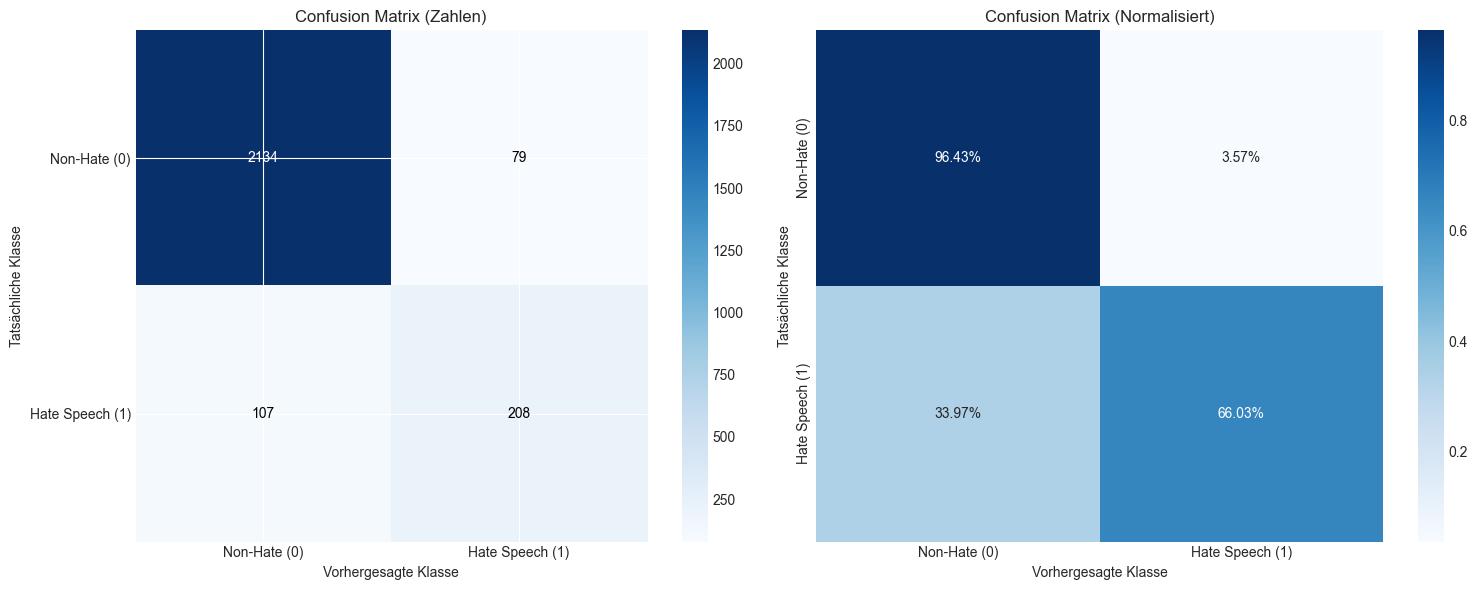


Confusion Matrix (Rohwerte):
                Predicted
                0      1
Actual  0     2134     79
        1      107    208

Confusion Matrix (Prozent):
                Predicted
                0      1
Actual  0     96.4%    3.6%
        1     34.0%   66.0%


In [144]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Erstelle zwei Visualisierungen: Zahlen und Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Confusion Matrix mit Zahlen
ax1 = axes[0]
im1 = ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax1.figure.colorbar(im1, ax=ax1)
ax1.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=['Non-Hate (0)', 'Hate Speech (1)'],
        yticklabels=['Non-Hate (0)', 'Hate Speech (1)'],
        title='Confusion Matrix (Zahlen)',
        ylabel='Tatsächliche Klasse',
        xlabel='Vorhergesagte Klasse')

# Füge Zahlen hinzu
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax1.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# 2. Confusion Matrix als Heatmap (normalisiert)
ax2 = axes[1]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax2,
            xticklabels=['Non-Hate (0)', 'Hate Speech (1)'],
            yticklabels=['Non-Hate (0)', 'Hate Speech (1)'])
ax2.set_title('Confusion Matrix (Normalisiert)')
ax2.set_ylabel('Tatsächliche Klasse')
ax2.set_xlabel('Vorhergesagte Klasse')

plt.tight_layout()
plt.show()

# Zeige Zahlen
print("\nConfusion Matrix (Rohwerte):")
print(f"                Predicted")
print(f"                0      1")
print(f"Actual  0    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"        1    {cm[1,0]:5d}  {cm[1,1]:5d}")

print(f"\nConfusion Matrix (Prozent):")
print(f"                Predicted")
print(f"                0      1")
print(f"Actual  0    {cm_normalized[0,0]*100:5.1f}%  {cm_normalized[0,1]*100:5.1f}%")
print(f"        1    {cm_normalized[1,0]*100:5.1f}%  {cm_normalized[1,1]*100:5.1f}%")


## 7. ROC Curve


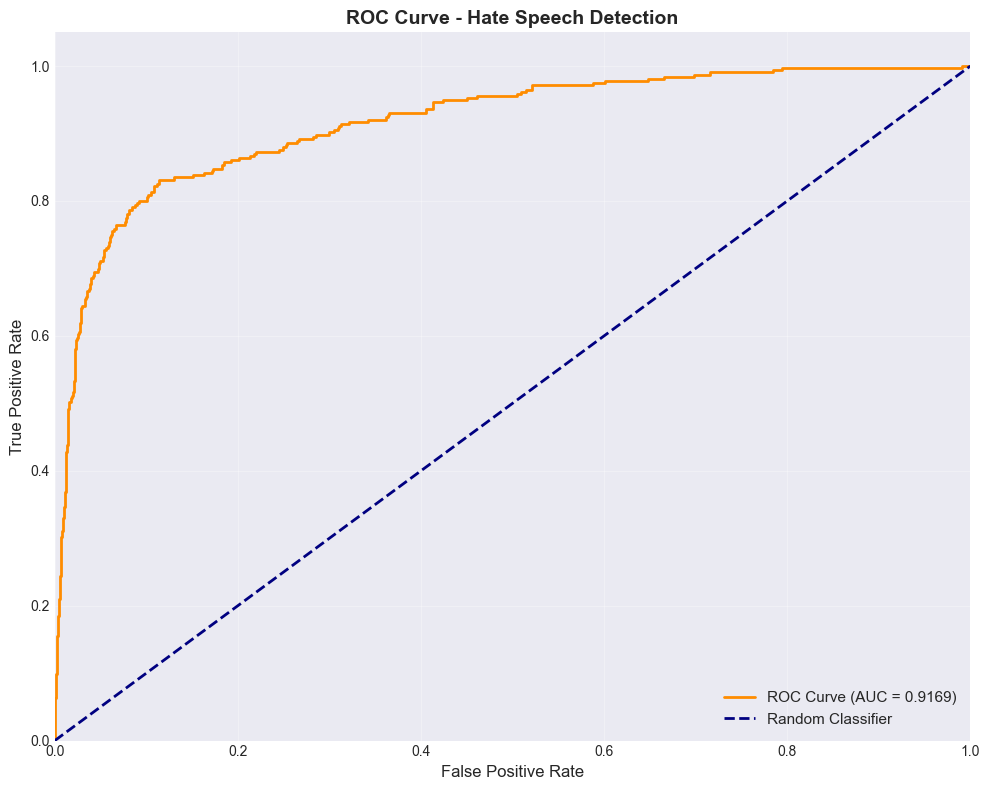

ROC AUC Score: 0.9169


In [145]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Hate Speech Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


## 8. Precision-Recall Curve


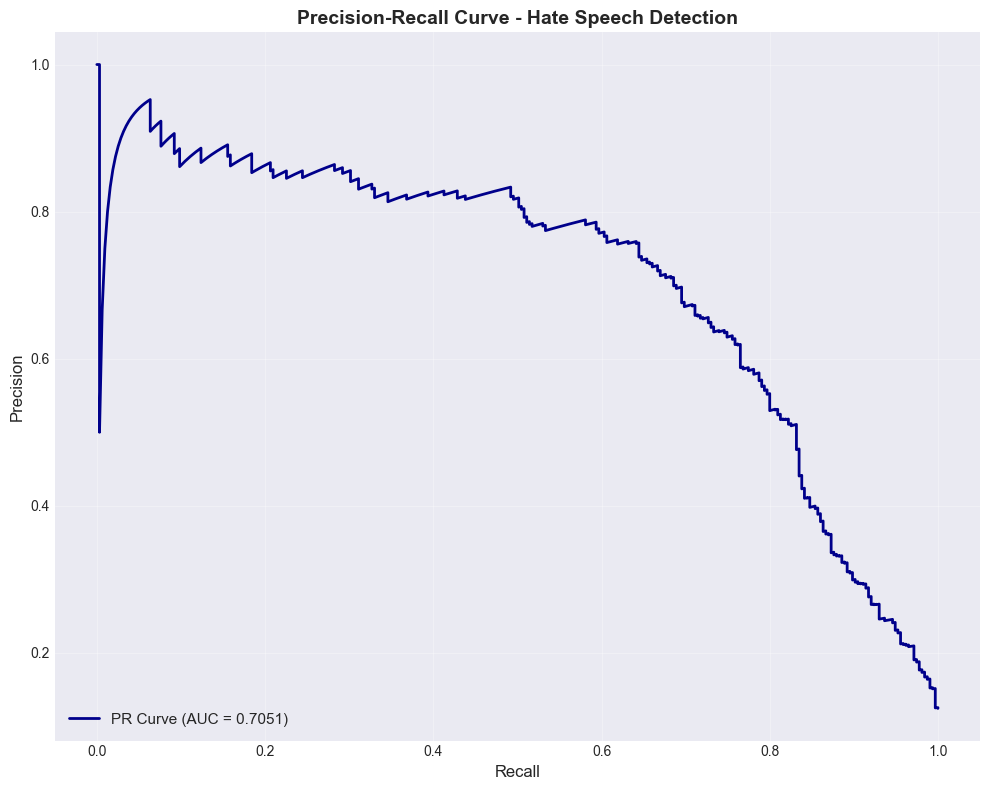

Precision-Recall AUC Score: 0.7051


In [146]:
# Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob[:, 1])
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='darkblue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Hate Speech Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Precision-Recall AUC Score: {pr_auc:.4f}")


## 9. Metriken-Vergleich (Bar Chart)


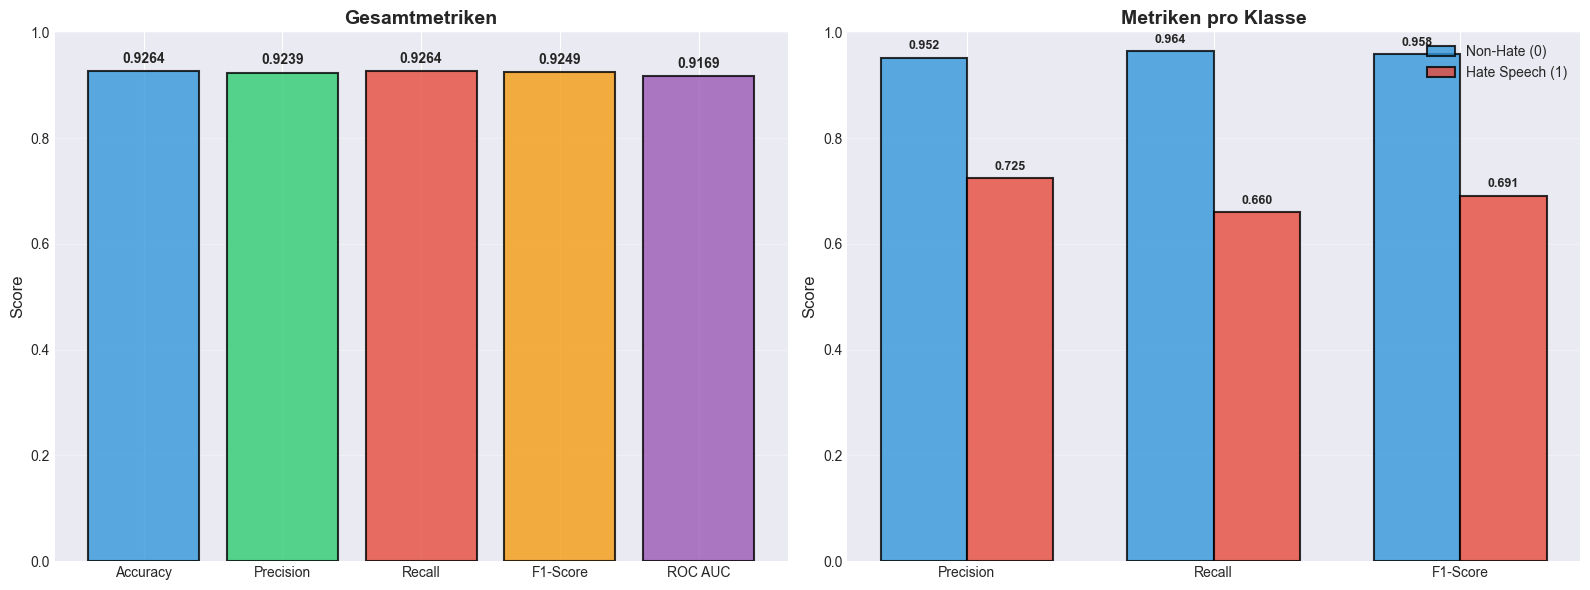

In [147]:
# Metriken-Vergleich
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Gesamtmetriken
ax1 = axes[0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
values = [accuracy, precision, recall, f1, roc_auc]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

bars = ax1.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylim([0, 1])
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Gesamtmetriken', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Füge Werte auf den Balken hinzu
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Metriken pro Klasse
ax2 = axes[1]
class_metrics = ['Precision', 'Recall', 'F1-Score']
class_0_values = [precision_0, recall_0, f1_0]
class_1_values = [precision_1, recall_1, f1_1]

x = np.arange(len(class_metrics))
width = 0.35

bars1 = ax2.bar(x - width/2, class_0_values, width, label='Non-Hate (0)', 
                color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax2.bar(x + width/2, class_1_values, width, label='Hate Speech (1)', 
                color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Metriken pro Klasse', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(class_metrics)
ax2.legend()
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Füge Werte auf den Balken hinzu
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


## 10. Wahrscheinlichkeitsverteilung


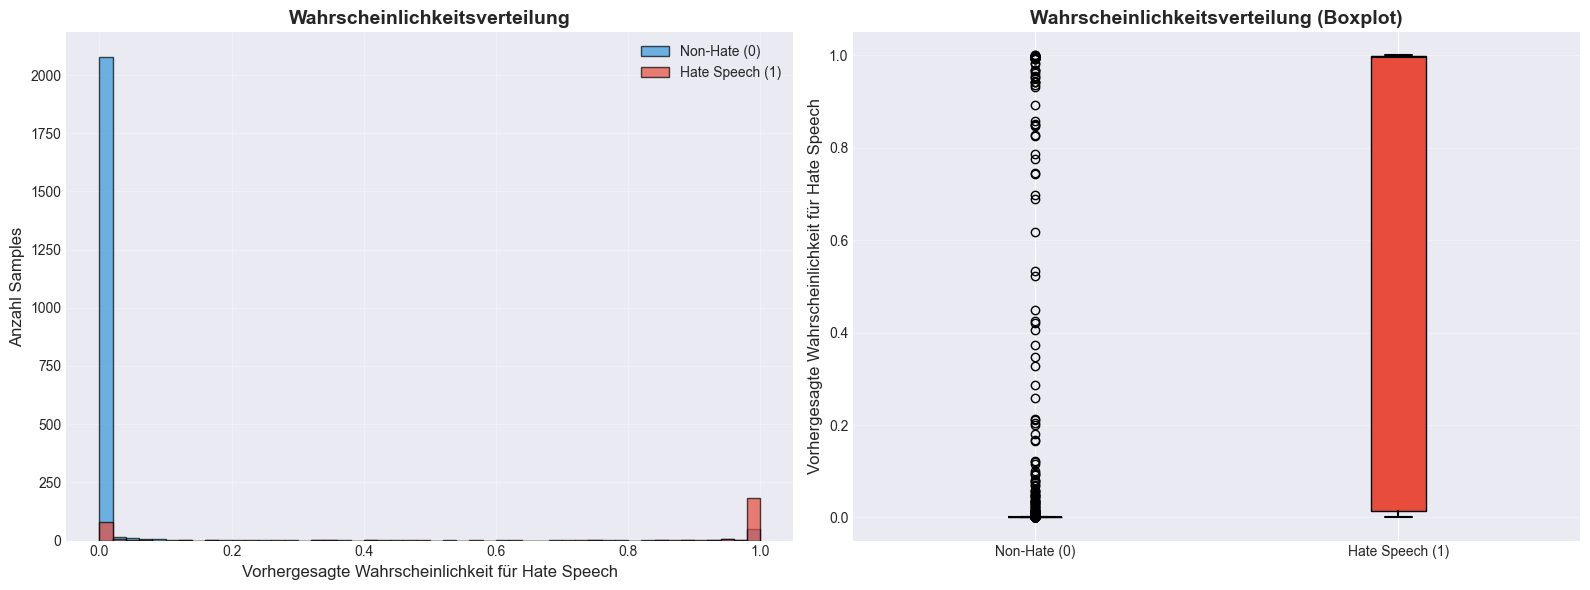

In [148]:
# Wahrscheinlichkeitsverteilung
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogramm der Wahrscheinlichkeiten
ax1 = axes[0]
ax1.hist(y_prob[y_true == 0, 1], bins=50, alpha=0.7, label='Non-Hate (0)', 
         color='#3498db', edgecolor='black')
ax1.hist(y_prob[y_true == 1, 1], bins=50, alpha=0.7, label='Hate Speech (1)', 
         color='#e74c3c', edgecolor='black')
ax1.set_xlabel('Vorhergesagte Wahrscheinlichkeit für Hate Speech', fontsize=12)
ax1.set_ylabel('Anzahl Samples', fontsize=12)
ax1.set_title('Wahrscheinlichkeitsverteilung', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Boxplot
ax2 = axes[1]
data_to_plot = [y_prob[y_true == 0, 1], y_prob[y_true == 1, 1]]
bp = ax2.boxplot(data_to_plot, labels=['Non-Hate (0)', 'Hate Speech (1)'], 
                 patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e74c3c')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black', linewidth=1.5)
ax2.set_ylabel('Vorhergesagte Wahrscheinlichkeit für Hate Speech', fontsize=12)
ax2.set_title('Wahrscheinlichkeitsverteilung (Boxplot)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 11. Fehleranalyse


FEHLERANALYSE

❌ Falsch Positive (FP): 79
   (Als Hate Speech vorhergesagt, aber eigentlich Non-Hate)
   Durchschnittliche Wahrscheinlichkeit: 0.9408

❌ Falsch Negative (FN): 107
   (Als Non-Hate vorhergesagt, aber eigentlich Hate Speech)
   Durchschnittliche Wahrscheinlichkeit: 0.0383

✅ Korrekt klassifiziert: 2342 (92.64%)


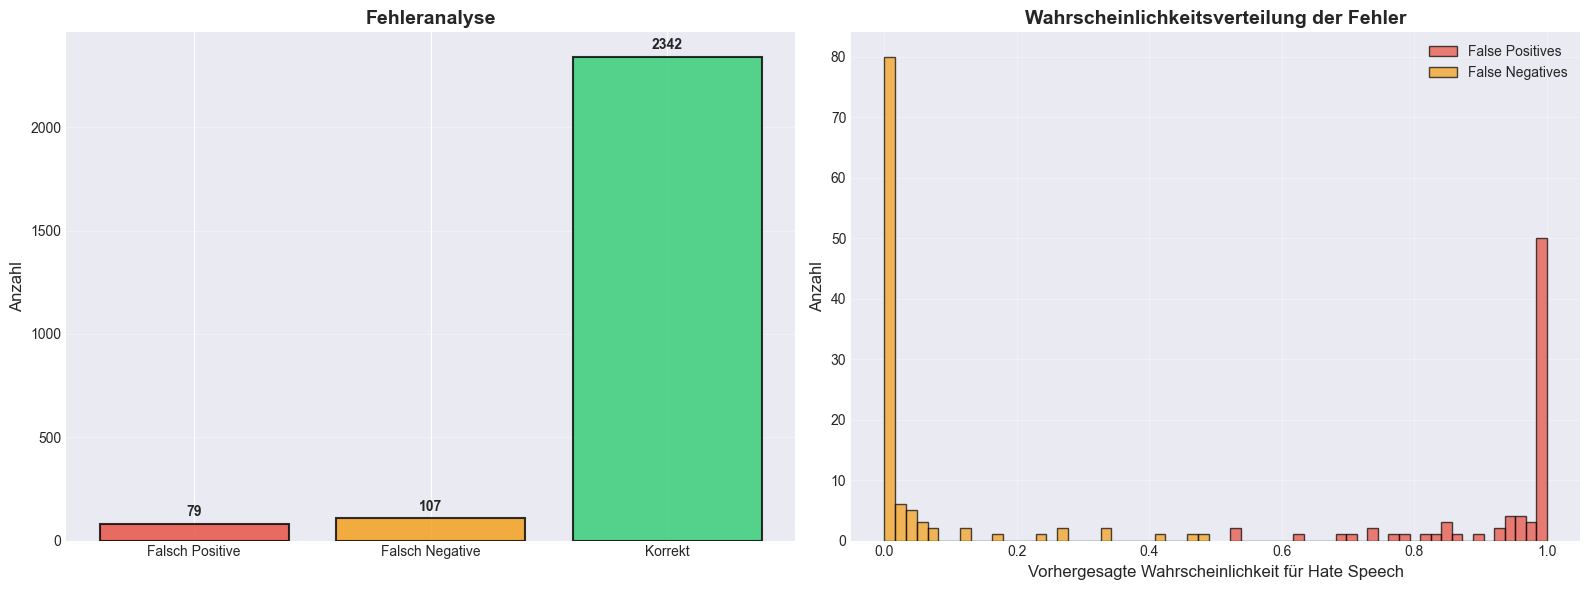


📝 Beispiele für Falsch Positive (erste 5):
   [0.995] Sie spricht von einer regelrechten "Trans-Mode". Keine Mode, sondern ein ganz natürliches Phänomen, ...
   [0.943] Twinkies sind ungesunde Snacks...
   [0.994] Immer dieses "Hast Du den zwei Meter Afrikaner gesehen? Der hat sicher 'nen riesigen..."... Man kann...
   [0.827] Ic h brauche kein Glasfaser , danke ....
   [0.999] Indigene Völker würden niemals versuchen, in den Weltraum zu fliegen, sie würden niemals versuchen, ...

📝 Beispiele für Falsch Negative (erste 5):
   [0.001] Die BILD schreibt: "Duschen und nach Hause gehen - WM-Aus für die Deutschen." Israel hat gar nicht e...
   [0.000] Merkel ist psycho:(...
   [0.036] Wobei wir aufpassen müssen weil die großkopferten das Bargeld abschaffen wollen wen wir nur noch mit...
   [0.489] Deutsch-Albaner, Schweden-Araber......schon interessant welche Nationalitäten hier im Zuge der polit...
   [0.001] die UN wird vom Vatikan diktiert! Was erwartet ihr, für diese Spiner gibt es nur

In [149]:
# Fehleranalyse
errors = val_df.copy()
errors['pred'] = y_pred
errors['prob_hate'] = y_prob[:, 1]
errors['correct'] = (errors['labels'] == errors['pred'])

# Falsch Positive (als Hate Speech vorhergesagt, aber eigentlich Non-Hate)
false_positives = errors[(errors['labels'] == 0) & (errors['pred'] == 1)]
# Falsch Negative (als Non-Hate vorhergesagt, aber eigentlich Hate Speech)
false_negatives = errors[(errors['labels'] == 1) & (errors['pred'] == 0)]

print("="*60)
print("FEHLERANALYSE")
print("="*60)
print(f"\n❌ Falsch Positive (FP): {len(false_positives)}")
print(f"   (Als Hate Speech vorhergesagt, aber eigentlich Non-Hate)")
print(f"   Durchschnittliche Wahrscheinlichkeit: {false_positives['prob_hate'].mean():.4f}")

print(f"\n❌ Falsch Negative (FN): {len(false_negatives)}")
print(f"   (Als Non-Hate vorhergesagt, aber eigentlich Hate Speech)")
print(f"   Durchschnittliche Wahrscheinlichkeit: {false_negatives['prob_hate'].mean():.4f}")

print(f"\n✅ Korrekt klassifiziert: {errors['correct'].sum()} ({errors['correct'].mean()*100:.2f}%)")

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Fehlertypen
ax1 = axes[0]
error_types = ['Falsch Positive', 'Falsch Negative', 'Korrekt']
error_counts = [len(false_positives), len(false_negatives), errors['correct'].sum()]
colors = ['#e74c3c', '#f39c12', '#2ecc71']

bars = ax1.bar(error_types, error_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Anzahl', fontsize=12)
ax1.set_title('Fehleranalyse', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, error_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(error_counts)*0.01,
            f'{count}', ha='center', va='bottom', fontweight='bold')

# 2. Wahrscheinlichkeitsverteilung für Fehler
ax2 = axes[1]
if len(false_positives) > 0:
    ax2.hist(false_positives['prob_hate'], bins=30, alpha=0.7, label='False Positives', 
             color='#e74c3c', edgecolor='black')
if len(false_negatives) > 0:
    ax2.hist(false_negatives['prob_hate'], bins=30, alpha=0.7, label='False Negatives', 
             color='#f39c12', edgecolor='black')
ax2.set_xlabel('Vorhergesagte Wahrscheinlichkeit für Hate Speech', fontsize=12)
ax2.set_ylabel('Anzahl', fontsize=12)
ax2.set_title('Wahrscheinlichkeitsverteilung der Fehler', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Zeige einige Beispiele
if len(false_positives) > 0:
    print(f"\n📝 Beispiele für Falsch Positive (erste 5):")
    for idx, row in false_positives.head(5).iterrows():
        print(f"   [{row['prob_hate']:.3f}] {row['text'][:100]}...")

if len(false_negatives) > 0:
    print(f"\n📝 Beispiele für Falsch Negative (erste 5):")
    for idx, row in false_negatives.head(5).iterrows():
        print(f"   [{row['prob_hate']:.3f}] {row['text'][:100]}...")


## 12. Zusammenfassung und Export


## 13. Modellvergleich: HuggingFace ONNX vs. SageMaker ONNX


MODELLVERGLEICH: HuggingFace ONNX (gbert-base) vs. SageMaker ONNX

📊 Metriken-Vergleich:
                        Model  Accuracy  Precision (Weighted)  Recall (Weighted)  F1-Score (Weighted)  ROC AUC  Precision (Class 0)  Recall (Class 0)  F1-Score (Class 0)  Precision (Class 1)  Recall (Class 1)  F1-Score (Class 1)
HuggingFace ONNX (gbert-base)  0.926424              0.923904           0.926424             0.924944 0.916855             0.952253          0.964302            0.958240             0.724739          0.660317            0.691030
               SageMaker ONNX  0.980222              0.980170           0.980222             0.980194 0.986283             0.988262          0.989155            0.988708             0.923323          0.917460            0.920382


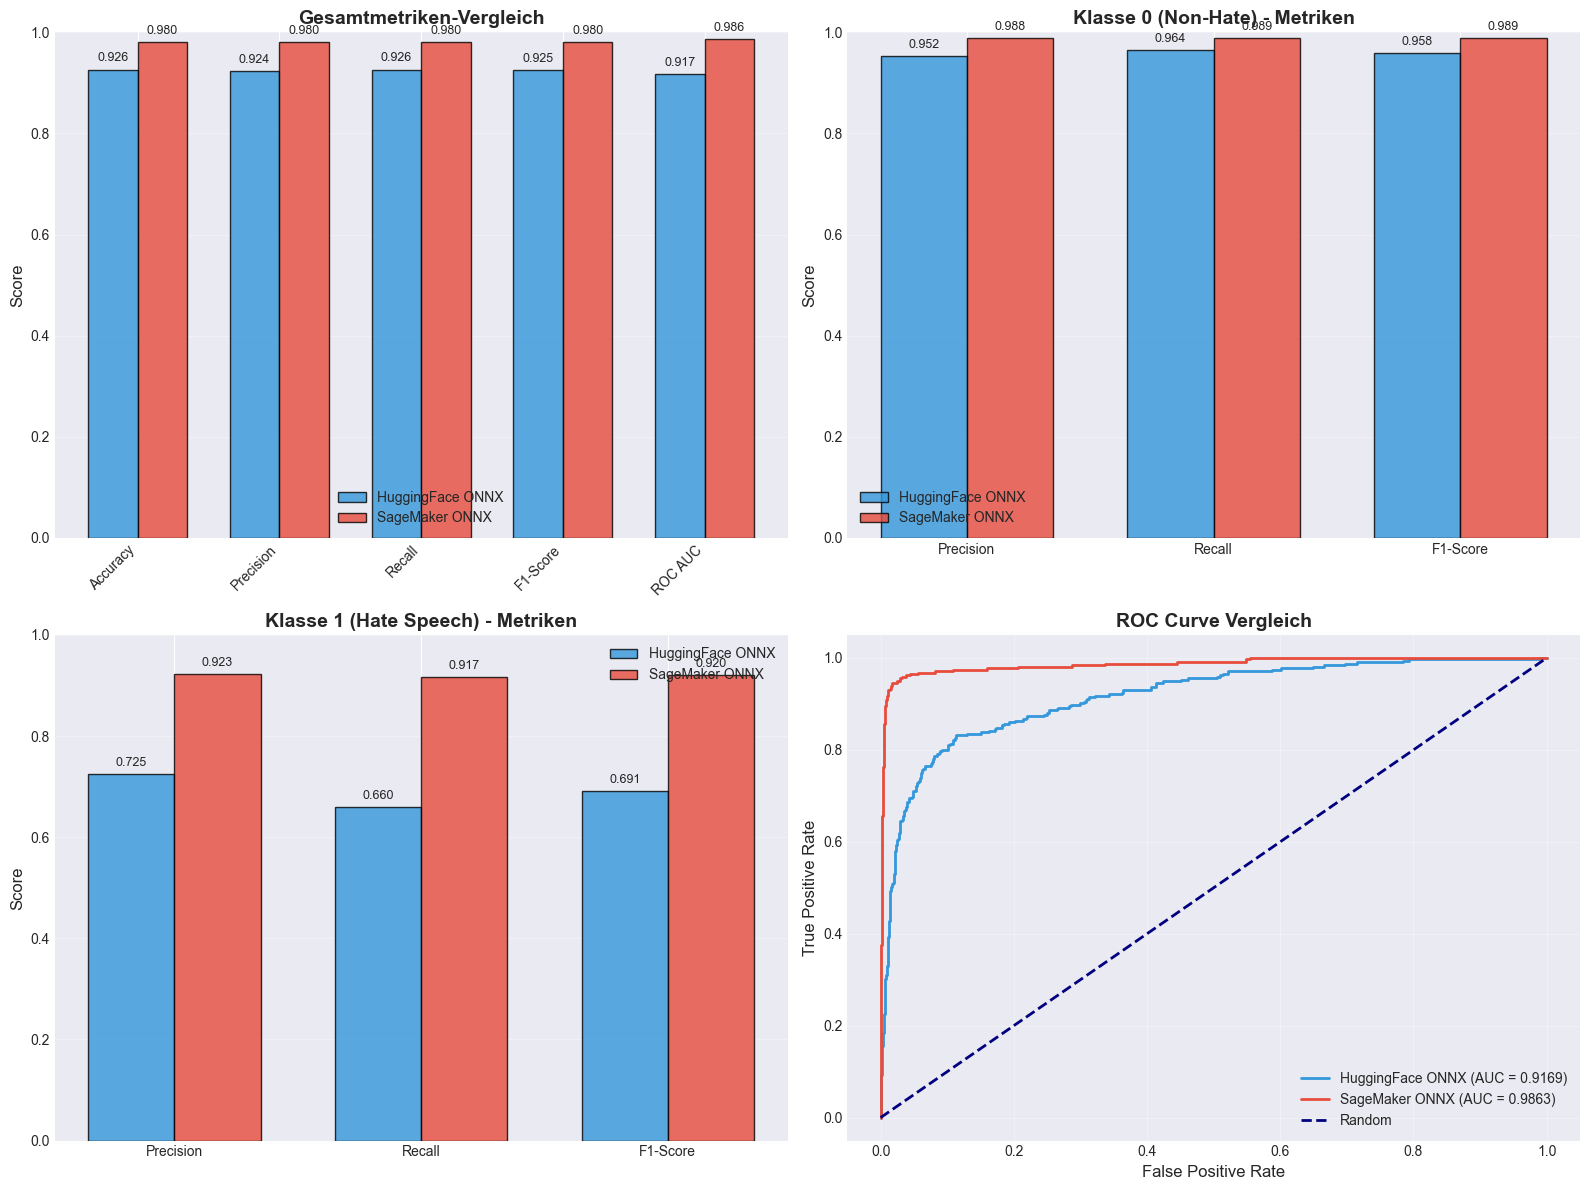


✅ Vergleich exportiert nach: validation_results/model_comparison.csv

ZUSAMMENFASSUNG DES VERGLEICHS

🏆 Besserer F1-Score (Weighted): SageMaker ONNX
   HuggingFace ONNX: 0.9249
   SageMaker ONNX:   0.9802

🏆 Besserer ROC AUC: SageMaker ONNX
   HuggingFace ONNX: 0.9169
   SageMaker ONNX:   0.9863


In [150]:
# Vergleich beider Modelle
if sagemaker_y_pred is not None and sagemaker_y_prob is not None:
    print("="*60)
    print("MODELLVERGLEICH: HuggingFace ONNX (gbert-base) vs. SageMaker ONNX")
    print("="*60)
    
    # Berechne Metriken für beide Modelle
    def calculate_metrics(y_true, y_pred, y_prob, model_name):
        """Berechne alle Metriken für ein Modell
        
        Erkennt automatisch, ob es sich um binäre oder multiclass Klassifikation handelt.
        """
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # Erkenne ob binär oder multiclass
        unique_classes = np.unique(np.concatenate([y_true, y_pred]))
        unique_true = np.unique(y_true)
        unique_pred = np.unique(y_pred)
        n_classes = len(unique_classes)
        is_binary = n_classes == 2
        
        # Pro Klasse - unterschiedliche Berechnung für binär vs. multiclass
        if is_binary:
            # Binäre Klassifikation: verwende pos_label
            precision_0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
            recall_0 = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
            f1_0 = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
            
            precision_1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
            recall_1 = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
            f1_1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
            
            # ROC AUC für binäre Klassifikation
            if y_prob.shape[1] >= 2:
                roc_auc = roc_auc_score(y_true, y_prob[:, 1])
            else:
                roc_auc = roc_auc_score(y_true, y_prob[:, 0] if y_prob.shape[1] == 1 else y_prob.flatten())
        else:
            # Multiclass: verwende average=None für Metriken pro Klasse
            # labels muss explizit angegeben werden, um die Reihenfolge zu garantieren
            precision_per_class = precision_score(y_true, y_pred, average=None, labels=unique_classes, zero_division=0)
            recall_per_class = recall_score(y_true, y_pred, average=None, labels=unique_classes, zero_division=0)
            f1_per_class = f1_score(y_true, y_pred, average=None, labels=unique_classes, zero_division=0)
            
            # Erstelle Mapping von Klassen-Label zu Index
            class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
            
            # Extrahiere Metriken für Klasse 0 und 1 (falls vorhanden)
            if 0 in class_to_idx:
                idx_0 = class_to_idx[0]
                precision_0 = precision_per_class[idx_0]
                recall_0 = recall_per_class[idx_0]
                f1_0 = f1_per_class[idx_0]
            else:
                precision_0 = 0.0
                recall_0 = 0.0
                f1_0 = 0.0
            
            if 1 in class_to_idx:
                idx_1 = class_to_idx[1]
                precision_1 = precision_per_class[idx_1]
                recall_1 = recall_per_class[idx_1]
                f1_1 = f1_per_class[idx_1]
            else:
                precision_1 = 0.0
                recall_1 = 0.0
                f1_1 = 0.0
            
            # ROC AUC für multiclass: verwende multi_class='ovr' (one-vs-rest)
            # ABER: Wenn y_true nur 2 Klassen hat, verwende binäre ROC AUC
            if len(np.unique(y_true)) == 2 and y_prob.shape[1] >= 2:
                # Binäre ROC AUC verwenden (auch wenn Modell 3 Klassen hat)
                try:
                    # Verwende Wahrscheinlichkeit für Klasse 1
                    if y_prob.shape[1] == 2:
                        roc_auc = roc_auc_score(y_true, y_prob[:, 1])
                    elif y_prob.shape[1] == 3:
                        # Kombiniere Klasse 1 und 2 für Hate Speech
                        prob_hate = y_prob[:, 1] + y_prob[:, 2]
                        roc_auc = roc_auc_score(y_true, prob_hate)
                    else:
                        roc_auc = 0.0
                except Exception as e:
                    roc_auc = 0.0
            else:
                # Echte multiclass ROC AUC
                try:
                    if y_prob.shape[1] == n_classes:
                        roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
                    else:
                        roc_auc = 0.0  # Fallback wenn Form nicht passt
                except Exception as e:
                    roc_auc = 0.0  # Fallback bei Fehler
        
        return {
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision (Weighted)': precision,
            'Recall (Weighted)': recall,
            'F1-Score (Weighted)': f1,
            'ROC AUC': roc_auc,
            'Precision (Class 0)': precision_0,
            'Recall (Class 0)': recall_0,
            'F1-Score (Class 0)': f1_0,
            'Precision (Class 1)': precision_1,
            'Recall (Class 1)': recall_1,
            'F1-Score (Class 1)': f1_1,
        }
    
    # Metriken für HuggingFace
    hf_metrics = calculate_metrics(y_true, hf_y_pred, hf_y_prob, "HuggingFace ONNX (gbert-base)")
    
    # Metriken für SageMaker
    sm_metrics = calculate_metrics(y_true, sagemaker_y_pred, sagemaker_y_prob, "SageMaker ONNX")
    
    # Erstelle Vergleichs-DataFrame
    comparison_df = pd.DataFrame([hf_metrics, sm_metrics])
    print("\n📊 Metriken-Vergleich:")
    print(comparison_df.to_string(index=False))
    
    # Visualisierung
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Gesamtmetriken
    ax1 = axes[0, 0]
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
    # Mapping von Anzeigenamen zu Dictionary-Schlüsseln
    metric_keys = {
        'Accuracy': 'Accuracy',
        'Precision': 'Precision (Weighted)',
        'Recall': 'Recall (Weighted)',
        'F1-Score': 'F1-Score (Weighted)',
        'ROC AUC': 'ROC AUC'
    }
    hf_values = [hf_metrics[metric_keys[m]] for m in metrics]
    sm_values = [sm_metrics[metric_keys[m]] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, hf_values, width, label='HuggingFace ONNX', 
                    color='#3498db', alpha=0.8, edgecolor='black')
    bars2 = ax1.bar(x + width/2, sm_values, width, label='SageMaker ONNX', 
                    color='#e74c3c', alpha=0.8, edgecolor='black')
    
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Gesamtmetriken-Vergleich', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics, rotation=45, ha='right')
    ax1.legend()
    ax1.set_ylim([0, 1])
    ax1.grid(axis='y', alpha=0.3)
    
    # Füge Werte hinzu
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 2. Metriken für Klasse 0
    ax2 = axes[0, 1]
    class0_metrics = ['Precision', 'Recall', 'F1-Score']
    hf_class0 = [hf_metrics['Precision (Class 0)'], hf_metrics['Recall (Class 0)'], 
                 hf_metrics['F1-Score (Class 0)']]
    sm_class0 = [sm_metrics['Precision (Class 0)'], sm_metrics['Recall (Class 0)'], 
                 sm_metrics['F1-Score (Class 0)']]
    
    x = np.arange(len(class0_metrics))
    bars1 = ax2.bar(x - width/2, hf_class0, width, label='HuggingFace ONNX', 
                    color='#3498db', alpha=0.8, edgecolor='black')
    bars2 = ax2.bar(x + width/2, sm_class0, width, label='SageMaker ONNX', 
                    color='#e74c3c', alpha=0.8, edgecolor='black')
    
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_title('Klasse 0 (Non-Hate) - Metriken', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(class0_metrics)
    ax2.legend()
    ax2.set_ylim([0, 1])
    ax2.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 3. Metriken für Klasse 1
    ax3 = axes[1, 0]
    class1_metrics = ['Precision', 'Recall', 'F1-Score']
    hf_class1 = [hf_metrics['Precision (Class 1)'], hf_metrics['Recall (Class 1)'], 
                 hf_metrics['F1-Score (Class 1)']]
    sm_class1 = [sm_metrics['Precision (Class 1)'], sm_metrics['Recall (Class 1)'], 
                 sm_metrics['F1-Score (Class 1)']]
    
    x = np.arange(len(class1_metrics))
    bars1 = ax3.bar(x - width/2, hf_class1, width, label='HuggingFace ONNX', 
                    color='#3498db', alpha=0.8, edgecolor='black')
    bars2 = ax3.bar(x + width/2, sm_class1, width, label='SageMaker ONNX', 
                    color='#e74c3c', alpha=0.8, edgecolor='black')
    
    ax3.set_ylabel('Score', fontsize=12)
    ax3.set_title('Klasse 1 (Hate Speech) - Metriken', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(class1_metrics)
    ax3.legend()
    ax3.set_ylim([0, 1])
    ax3.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 4. ROC Curves Vergleich
    ax4 = axes[1, 1]
    
    # HuggingFace ROC
    fpr_hf, tpr_hf, _ = roc_curve(y_true, hf_y_prob[:, 1])
    roc_auc_hf = auc(fpr_hf, tpr_hf)
    ax4.plot(fpr_hf, tpr_hf, color='#3498db', lw=2, 
             label=f'HuggingFace ONNX (AUC = {roc_auc_hf:.4f})')
    
    # SageMaker ROC
    if sagemaker_y_prob.shape[1] >= 2:
        sm_prob_class1 = sagemaker_y_prob[:, 1]
    else:
        sm_prob_class1 = sagemaker_y_prob[:, 0] if sagemaker_y_prob.shape[1] == 1 else sagemaker_y_prob.flatten()
    
    fpr_sm, tpr_sm, _ = roc_curve(y_true, sm_prob_class1)
    roc_auc_sm = auc(fpr_sm, tpr_sm)
    ax4.plot(fpr_sm, tpr_sm, color='#e74c3c', lw=2, 
             label=f'SageMaker ONNX (AUC = {roc_auc_sm:.4f})')
    
    ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax4.set_xlabel('False Positive Rate', fontsize=12)
    ax4.set_ylabel('True Positive Rate', fontsize=12)
    ax4.set_title('ROC Curve Vergleich', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Speichere Vergleich
    comparison_df.to_csv(output_dir / "model_comparison.csv", index=False, encoding="utf-8-sig")
    print(f"\n✅ Vergleich exportiert nach: {output_dir}/model_comparison.csv")
    
    # Zusammenfassung
    print("\n" + "="*60)
    print("ZUSAMMENFASSUNG DES VERGLEICHS")
    print("="*60)
    
    better_model = "HuggingFace ONNX" if hf_metrics['F1-Score (Weighted)'] > sm_metrics['F1-Score (Weighted)'] else "SageMaker ONNX"
    print(f"\n🏆 Besserer F1-Score (Weighted): {better_model}")
    print(f"   HuggingFace ONNX: {hf_metrics['F1-Score (Weighted)']:.4f}")
    print(f"   SageMaker ONNX:   {sm_metrics['F1-Score (Weighted)']:.4f}")
    
    better_roc = "HuggingFace ONNX" if hf_metrics['ROC AUC'] > sm_metrics['ROC AUC'] else "SageMaker ONNX"
    print(f"\n🏆 Besserer ROC AUC: {better_roc}")
    print(f"   HuggingFace ONNX: {hf_metrics['ROC AUC']:.4f}")
    print(f"   SageMaker ONNX:   {sm_metrics['ROC AUC']:.4f}")
    
    print("="*60)
    
else:
    print("⚠️  SageMaker ONNX-Modell nicht verfügbar - Vergleich kann nicht durchgeführt werden")
    print("   Mögliche Ursachen:")
    print("   1. ONNX-Konvertierung fehlgeschlagen")
    print("   2. HuggingFace-Modell-Verzeichnis im SageMaker-Ordner nicht gefunden")
    print("   3. Optimum nicht verfügbar für Konvertierung")


## Vergleichstabelle: Alle Metriken im Überblick


DETAILLIERTE METRIKEN-VERGLEICHSTABELLE


              Metrik HuggingFace ONNX (gbert-base) SageMaker ONNX
            Accuracy                        0.9264         0.9802
Precision (Weighted)                        0.9239         0.9802
   Recall (Weighted)                        0.9264         0.9802
 F1-Score (Weighted)                        0.9249         0.9802
             ROC AUC                        0.9169         0.9863
                                                                 
Precision (Klasse 0)                        0.9523         0.9883
   Recall (Klasse 0)                        0.9643         0.9892
 F1-Score (Klasse 0)                        0.9582         0.9887
                                                                 
Precision (Klasse 1)                        0.7247         0.9233
   Recall (Klasse 1)                        0.6603         0.9175
 F1-Score (Klasse 1)                        0.6910         0.9204



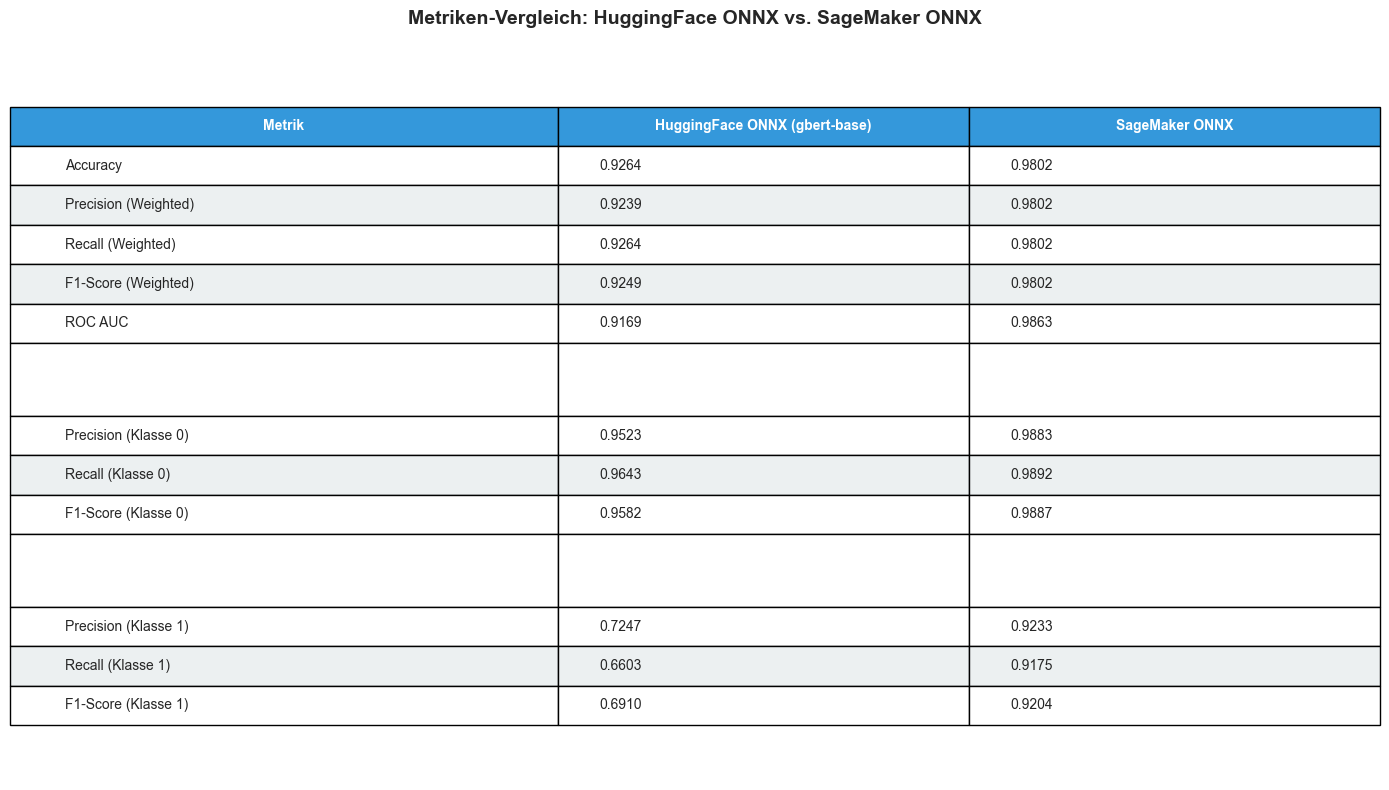


✅ Vergleichstabelle erstellt


In [151]:
# Erstelle detaillierte Vergleichstabelle
if sagemaker_y_pred is not None and sagemaker_y_prob is not None and hf_y_pred is not None:
    print("="*80)
    print("DETAILLIERTE METRIKEN-VERGLEICHSTABELLE")
    print("="*80)
    
    # Erstelle Vergleichstabelle
    comparison_data = {
        'Metrik': [
            'Accuracy',
            'Precision (Weighted)',
            'Recall (Weighted)',
            'F1-Score (Weighted)',
            'ROC AUC',
            '',
            'Precision (Klasse 0)',
            'Recall (Klasse 0)',
            'F1-Score (Klasse 0)',
            '',
            'Precision (Klasse 1)',
            'Recall (Klasse 1)',
            'F1-Score (Klasse 1)'
        ],
        'HuggingFace ONNX (gbert-base)': [
            f"{hf_metrics['Accuracy']:.4f}",
            f"{hf_metrics['Precision (Weighted)']:.4f}",
            f"{hf_metrics['Recall (Weighted)']:.4f}",
            f"{hf_metrics['F1-Score (Weighted)']:.4f}",
            f"{hf_metrics['ROC AUC']:.4f}",
            '',
            f"{hf_metrics['Precision (Class 0)']:.4f}",
            f"{hf_metrics['Recall (Class 0)']:.4f}",
            f"{hf_metrics['F1-Score (Class 0)']:.4f}",
            '',
            f"{hf_metrics['Precision (Class 1)']:.4f}",
            f"{hf_metrics['Recall (Class 1)']:.4f}",
            f"{hf_metrics['F1-Score (Class 1)']:.4f}"
        ],
        'SageMaker ONNX': [
            f"{sm_metrics['Accuracy']:.4f}",
            f"{sm_metrics['Precision (Weighted)']:.4f}",
            f"{sm_metrics['Recall (Weighted)']:.4f}",
            f"{sm_metrics['F1-Score (Weighted)']:.4f}",
            f"{sm_metrics['ROC AUC']:.4f}",
            '',
            f"{sm_metrics['Precision (Class 0)']:.4f}",
            f"{sm_metrics['Recall (Class 0)']:.4f}",
            f"{sm_metrics['F1-Score (Class 0)']:.4f}",
            '',
            f"{sm_metrics['Precision (Class 1)']:.4f}",
            f"{sm_metrics['Recall (Class 1)']:.4f}",
            f"{sm_metrics['F1-Score (Class 1)']:.4f}"
        ]
    }
    
    comparison_table = pd.DataFrame(comparison_data)
    
    # Zeige Tabelle
    print("\n")
    print(comparison_table.to_string(index=False))
    print("\n" + "="*80)
    
    # Erstelle auch eine visuelle Tabelle mit besserer Formatierung
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # Erstelle Tabelle
    table_data = []
    for i in range(len(comparison_data['Metrik'])):
        if comparison_data['Metrik'][i] == '':
            table_data.append(['', '', ''])  # Leere Zeile
        else:
            table_data.append([
                comparison_data['Metrik'][i],
                comparison_data['HuggingFace ONNX (gbert-base)'][i],
                comparison_data['SageMaker ONNX'][i]
            ])
    
    table = ax.table(
        cellText=table_data,
        colLabels=['Metrik', 'HuggingFace ONNX (gbert-base)', 'SageMaker ONNX'],
        cellLoc='left',
        loc='center',
        colWidths=[0.4, 0.3, 0.3]
    )
    
    # Formatierung
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Header formatieren
    for i in range(3):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Zeilen formatieren
    for i in range(1, len(table_data) + 1):
        if i % 2 == 0:
            for j in range(3):
                table[(i, j)].set_facecolor('#ecf0f1')
        else:
            for j in range(3):
                table[(i, j)].set_facecolor('#ffffff')
        
        # Leere Zeilen
        if table_data[i-1][0] == '':
            for j in range(3):
                table[(i, j)].set_facecolor('#ffffff')
                table[(i, j)].set_height(0.1)
    
    # Titel
    plt.title('Metriken-Vergleich: HuggingFace ONNX vs. SageMaker ONNX', 
              fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Vergleichstabelle erstellt")
else:
    print("⚠️  Beide Modelle müssen verfügbar sein, um die Vergleichstabelle zu erstellen")


In [152]:
# Erstelle Zusammenfassung
summary = {
    'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)', 
               'ROC AUC', 'PR AUC',
               'Precision (Class 0)', 'Recall (Class 0)', 'F1-Score (Class 0)',
               'Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)'],
    'Value': [accuracy, precision, recall, f1, roc_auc, pr_auc,
              precision_0, recall_0, f1_0, precision_1, recall_1, f1_1]
}

summary_df = pd.DataFrame(summary)
print("="*60)
print("ZUSAMMENFASSUNG DER VALIDIERUNG")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)

# Exportiere Ergebnisse
output_dir = Path("validation_results")
output_dir.mkdir(exist_ok=True)

# Speichere Zusammenfassung
summary_df.to_csv(output_dir / "validation_summary.csv", index=False, encoding="utf-8-sig")

# Speichere detaillierte Ergebnisse
errors['prob_hate'] = y_prob[:, 1]
errors.to_csv(output_dir / "validation_predictions.csv", index=False, encoding="utf-8-sig")

# Speichere Fehlerbeispiele
if len(false_positives) > 0:
    false_positives.to_csv(output_dir / "false_positives.csv", index=False, encoding="utf-8-sig")
if len(false_negatives) > 0:
    false_negatives.to_csv(output_dir / "false_negatives.csv", index=False, encoding="utf-8-sig")

print(f"\n✅ Ergebnisse exportiert nach: {output_dir}")
print(f"   - validation_summary.csv")
print(f"   - validation_predictions.csv")
if len(false_positives) > 0:
    print(f"   - false_positives.csv")
if len(false_negatives) > 0:
    print(f"   - false_negatives.csv")


ZUSAMMENFASSUNG DER VALIDIERUNG
              Metric    Value
            Accuracy 0.926424
Precision (Weighted) 0.923904
   Recall (Weighted) 0.926424
 F1-Score (Weighted) 0.924944
             ROC AUC 0.916855
              PR AUC 0.705116
 Precision (Class 0) 0.952253
    Recall (Class 0) 0.964302
  F1-Score (Class 0) 0.958240
 Precision (Class 1) 0.724739
    Recall (Class 1) 0.660317
  F1-Score (Class 1) 0.691030

✅ Ergebnisse exportiert nach: validation_results
   - validation_summary.csv
   - validation_predictions.csv
   - false_positives.csv
   - false_negatives.csv
